# Toronto Dwellings Analysis Dashboard

In this notebook, you will compile the visualizations from the previous analysis into functions to create a Panel dashboard.

In [13]:
# imports
import panel as pn
pn.extension('plotly')
import plotly.express as px
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
import os
from pathlib import Path
from dotenv import load_dotenv

In [14]:
# Initialize the Panel Extensions (for Plotly)
import panel as pn
pn.extension("plotly")

In [15]:
# Read the Mapbox API key
load_dotenv()
map_box_api = os.getenv("MAPBOX_API")
px.set_mapbox_access_token(map_box_api)

# Import Data

In [16]:
# Import the CSVs to Pandas DataFrames
file_path = Path("toronto_neighbourhoods_census_data.csv")
to_data = pd.read_csv(file_path, index_col="year")

file_path = Path("toronto_neighbourhoods_coordinates.csv")
df_neighbourhood_locations = pd.read_csv(file_path)

- - -

## Panel Visualizations

In this section, you will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. 

These functions will convert the plot object to a Panel pane.

Be sure to include any DataFrame transformation/manipulation code required along with the plotting code.

Return a Panel pane object from each function that can be used to build the dashboard.

Note: Remove any `.show()` lines from the code. We want to return the plots instead of showing them. The Panel dashboard will then display the plots.

### Global available data

In [17]:
# Getting the data from the top 10 expensive neighbourhoods
# Create a list with the dwelling types
dwelling_types = [
    "single_detached_house",
    "apartment_five_storeys_plus",
    "movable_dwelling",
    "semi_detached_house",
    "row_house",
    "duplex",
    "apartment_five_storeys_less",
    "other_house"
]

# Getting the data from the top 10 expensive neighbourhoods
df_expensive_neighbourhoods = to_data.groupby(by="neighbourhood").mean()
df_expensive_neighbourhoods = df_expensive_neighbourhoods.sort_values(
    by="average_house_value", ascending=False
).head(10)
df_expensive_neighbourhoods = df_expensive_neighbourhoods.reset_index()

# Calculate the mean number of dwelling types units per year
df_dwelling_units = to_data[dwelling_types].groupby(to_data.index).sum()

# Calculate the average monthly shelter costs for owned and rented dwellings
df_avg_costs = (
    to_data[["shelter_costs_owned", "shelter_costs_rented"]]
    .groupby([to_data.index])
    .mean()
)

### Panel Visualization Functions

In [18]:
# Define Panel visualization functions
def neighbourhood_map():
    """Neighbourhood Map"""
   
    # Calculate the mean values for each neighborhood
    df_all_neighbourhoods = to_data.groupby(by="neighbourhood").mean()
    df_all_neighbourhoods = df_all_neighbourhoods.reset_index()

    # Join the average values with the neighbourhood locations
    df_all_neighbourhoods = pd.merge(
        df_neighbourhood_locations, df_all_neighbourhoods, on="neighbourhood"
    )

    map = px.scatter_mapbox(
        df_all_neighbourhoods,
        lat="lat",
        lon="lon",
        size="average_house_value",
        color="average_house_value",
        color_continuous_scale=px.colors.cyclical.IceFire,
        size_max=15,
        zoom=9,
        hover_name="neighbourhood",
        hover_data = [
            "shelter_costs_owned",
            "shelter_costs_rented",
            "single_detached_house",
            "apartment_five_storeys_plus",
            "movable_dwelling",
            "semi_detached_house",
            "row_house",
            "duplex",
            "apartment_five_storeys_less",
            "other_house"
        ],
        title="Average House Values in Toronto",
        width = 1024,
        height=600
    )
    
    # Define the Plotly pane
    plotly_panel = pn.pane.Plotly(map)
    plotly_panel._updates = True
    
    return plotly_panel

def create_bar_chart(data, title, xlabel, ylabel, color):
    """
    Create a barplot based in the data argument.
    """
    
    fig = plt.figure(figsize=(6, 5))
    bar_chart = data.plot.bar(color=color)
    bar_chart.set_xlabel(xlabel, fontsize=12)
    bar_chart.set_ylabel(ylabel, fontsize=12)
    bar_chart.set_title(title, fontsize=14, fontweight="bold")
    plt.close(fig)
    
    return pn.pane.Matplotlib(fig, tight=True)

def create_line_chart(data, title, xlabel, ylabel, color):
    """
    Create a line chart based in the data argument.
    """
    
    fig = plt.figure(figsize=(8, 4))
    bar_chart = data.plot(color=color)
    bar_chart.set_xlabel(xlabel, fontsize=12)
    bar_chart.set_ylabel(ylabel, fontsize=12)
    bar_chart.set_title(title, fontsize=14, fontweight="bold")    
    plt.close(fig)
    
    return pn.pane.Matplotlib(fig, tight=True)

def average_house_value():
    """Average house values per year."""
    
    # Calculate the average house value per
    df_avg_value = (
        to_data["average_house_value"]
        .groupby([to_data.index])
        .mean()
    )
    
    # Plot the average house value per year as a line chart
    fig_avg_sale_price = plt.figure(figsize=(8, 4))
    plot_avg_sale_price = df_avg_value.plot()
    plot_avg_sale_price.set_xlabel("Year", fontsize=12)
    plot_avg_sale_price.set_ylabel("Avg. House Value", fontsize=12)
    plot_avg_sale_price.set_title(
        "Average House Value in Toronto",
        fontsize=14,
        fontweight="bold",
    )

    # Close the plot
    plt.close(fig_avg_sale_price)
    
    return pn.pane.Matplotlib(fig_avg_sale_price, tight=True)

def average_value_by_neighbourhood():
    """Average house values by neighbourhood."""
    
    # Create a new DataFrame with the mean house values by neighbourhood per year
    df_average_value = to_data[["neighbourhood", "average_house_value"]]
    df_average_value = df_average_value.reset_index()
    
    # Use hvplot to create an interactive line chart of the average house value per neighbourhood
    house_value_curve = df_average_value.hvplot.line(
        "year",
        "average_house_value",
        xlabel="Year",
        ylabel="Avg. House Value",
        groupby="neighbourhood",
    )
    
    return house_value_curve

def number_dwelling_types():
    """Number of dwelling types per year"""
    
    # Fetch the data of all dwelling types per year
    df_number_dwellings = to_data.reset_index()
    
    # Use hvplot to create an interactive bar chart of the number of dwelling types per neighbourhood
    # The plot should have a dropdown selector for the neighbourhood
    number_dwellings_plot = df_number_dwellings.hvplot.bar(
        "year",
        dwelling_types,
        xlabel="Year",
        ylabel="Dwelling Type Units",
        rot=90,
        height=500,
        groupby="neighbourhood",
    )
    
    return number_dwellings_plot

def average_house_value_snapshot():
    """Average house value for all Toronto's neighbourhoods per year."""

    fig = px.bar(
        to_data,
        x="neighbourhood",
        y="average_house_value",
        color="average_house_value",
        height=1024,
        facet_row=to_data.index,
        title="Average House Values in Toronto per Neighbourhood",
        labels={
            "neighbourhood": "Neighbourhoods",
            "average_house_value": "Avg. House Value"
        }
    )
    
    return fig

def top_most_expensive_neighbourhoods():
    """Top 10 most expensive neighbourhoods."""
    
    expensive_neighbourhoods = df_expensive_neighbourhoods.hvplot.bar(
        "neighbourhood",
        "average_house_value",
        title="Top 10 Expensive Neighbourhoods in Toronto",
        xlabel="Neighbourhood",
        ylabel="Avg. House Value",
        height=500,
        rot=90,
        ylim=(0, 1600000)
    )
    
    return expensive_neighbourhoods

def sunburts_cost_analysis():
    """Sunburst chart to conduct a costs analysis of most expensive neighbourhoods in Toronto per year."""
    
    # Fetch the data from all expensive neighbourhoods per year.
    df_expensive_neighbourhoods_per_year = to_data[to_data["neighbourhood"].isin(df_expensive_neighbourhoods["neighbourhood"])]
    df_expensive_neighbourhoods_per_year = df_expensive_neighbourhoods_per_year.reset_index()
    
    fig = px.sunburst(
        df_expensive_neighbourhoods_per_year,
        path=["year", "neighbourhood"],
        values='average_house_value',
        color='shelter_costs_owned',
        hover_data=['shelter_costs_owned', 'shelter_costs_rented'],
        color_continuous_scale='Blues',
        title="Costs Analysis of Most Expensive Neighbourhoods in Toronto per Year"
    )
    
    return fig

## Panel Dashboard

In this section, you will combine all of the plots into a single dashboard view using Panel. Be creative with your dashboard design!

In [19]:
# Create a Title for the Dashboard
title = pn.pane.Markdown(
    """
# Real Estate Analysis of Toronto from 2001 to 2016
""",
    width=800,
)

# Define a welcome text
welcome = pn.pane.Markdown(
    """
This dashboard presents a visual analysis of historical house values,
dwelling types per neighbourhood and dwelling costs in Toronto, Ontario
according to census data from 2001 to 2016. You can navigate through the tabs above
to explore more details about the evolution of the real estate market on across these years.
""",
    width=1024,
)

# Create a tab layout for the dashboard
tabs = pn.Tabs(
    # First tab
    (
        "Welcome",
        pn.Column(
            welcome,
            neighbourhood_map()
        )
    ),
    # Second tab
    (
        "Yearly Market Analysis",
        pn.Column(
                pn.Row(
                    create_bar_chart(
                        df_dwelling_units.loc[2001],
                        "Dwelling Types in Toronto in 2001",
                        "2001",
                        "Dwelling Type Units",
                        "red"
                    ),
                    create_bar_chart(
                        df_dwelling_units.loc[2006],
                        "Dwelling Types in Toronto in 2006",
                        "2006",
                        "Dwelling Type Units",
                        "blue"
                    ),
                ),
                pn.Row(
                    create_bar_chart(
                        df_dwelling_units.loc[2011],
                        "Dwelling Types in Toronto in 2011",
                        "2011",
                        "Dwelling Type Units",
                        "orange"
                    ),
                    create_bar_chart(
                        df_dwelling_units.loc[2016],
                        "Dwelling Types in Toronto in 2016",
                        "2016",
                        "Dwelling Type Units",
                        "magenta"
                    ),                    
                )
        )
    ),
    # Third tab
    (
        "Shelter Costs Vs. House Value",
        pn.Column(
            create_line_chart(
                df_avg_costs["shelter_costs_owned"],
                "Average Monthly Shelter Cost for Owned Dwellings in Toronto",
                "Year",
                "Avg Monthly Shelter Costs",
                "blue"
            ),
            create_line_chart(
                df_avg_costs["shelter_costs_rented"],
                "Average Monthly Shelter Cost for Rented Dwellings in Toronto",
                "Year",
                "Avg Monthly Shelter Costs",
                "orange"
            ),
            average_house_value(),
        ),
    ),
    # Forth Tab
    (
        "Neighbourhood Analysis",
        pn.Row(
            pn.Column(
                average_value_by_neighbourhood(),
                number_dwelling_types(),
            ),
            pn.Column(
                average_house_value_snapshot(),
            )
        )
    ),
    # Fifth tab
    (
        "Top Expensive Neighbourhoods",
        pn.Row(
            top_most_expensive_neighbourhoods(),
            sunburts_cost_analysis(),
        )
    )
)

# Create the main dashboard
dashboard = pn.Column(
    pn.Row(title),
    tabs,
    width=1024,
    height=768
)

## Serve the Panel Dashboard

Column(height=768, sizing_mode='fixed', width=1024)
    [0] Row
        [0] Markdown(str, width=800)
    [1] Tabs
        [0] Column
            [0] Markdown(str, width=1024)
            [1] Plotly(Figure)
        [1] Column
            [0] Row
                [0] Matplotlib(Figure, tight=True)
                [1] Matplotlib(Figure, tight=True)
            [1] Row
                [0] Matplotlib(Figure, tight=True)
                [1] Matplotlib(Figure, tight=True)
        [2] Column
            [0] Matplotlib(Figure, tight=True)
            [1] Matplotlib(Figure, tight=True)
            [2] Matplotlib(Figure, tight=True)
        [3] Row
            [0] Column
                [0] Row
                    [0] HoloViews(DynamicMap)
                    [1] Column
                        [0] WidgetBox
                            [0] Select(margin=(20, 20, 20, 20), name='neighbourhood', options=['Agincourt North', ...], value='Agincourt North', width=250)
                        [1] VSpacer()
                [1] Row
                    [0] HoloViews(DynamicMap)
                    [1] Column
                        [0] WidgetBox
                            [0] Select(margin=(20, 20, 20, 20), name='neighbourhood', options=['Agincourt North', ...], value='Agincourt North', width=250)
                        [1] VSpacer()
            [1] Column
                [0] Plotly(Figure)
        [4] Row
            [0] HoloViews(Bars)
            [1] Plotly(Figure)
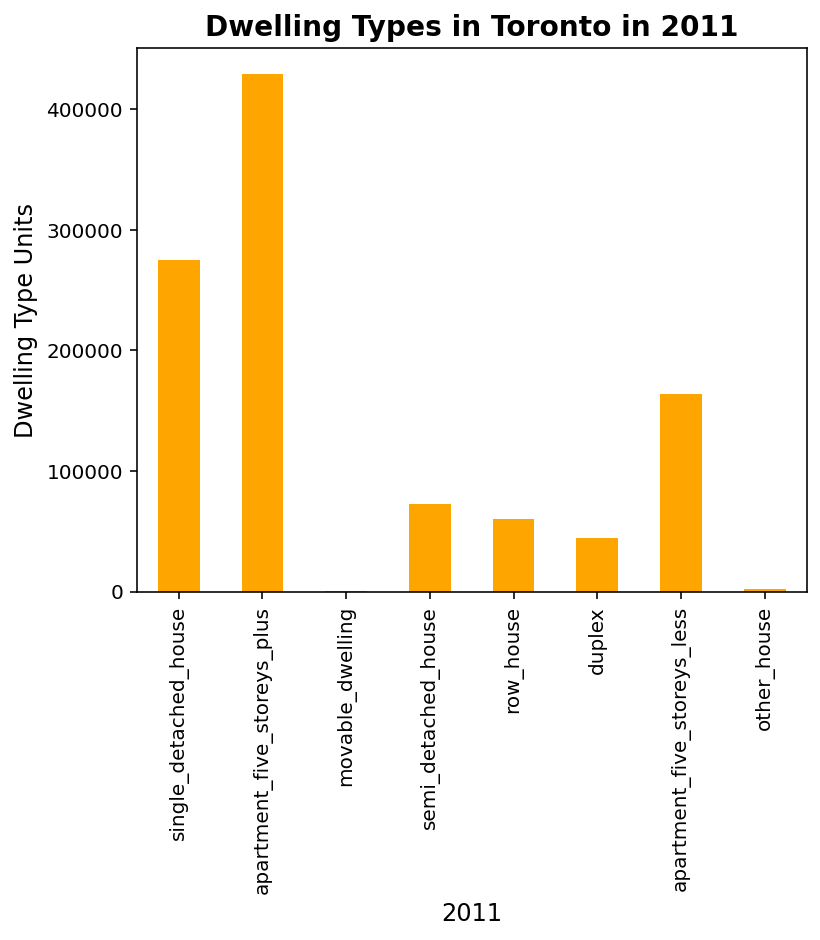
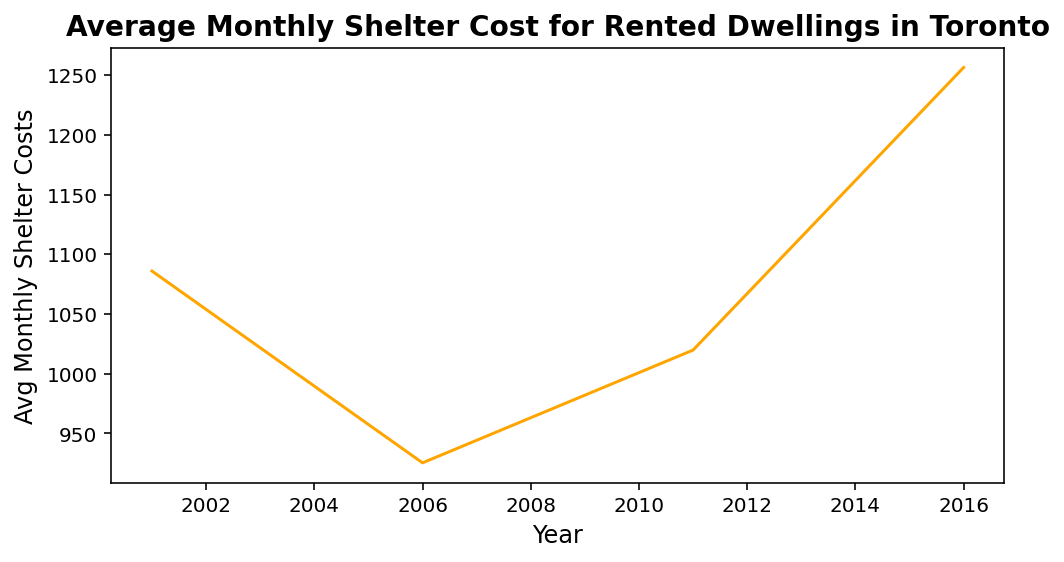
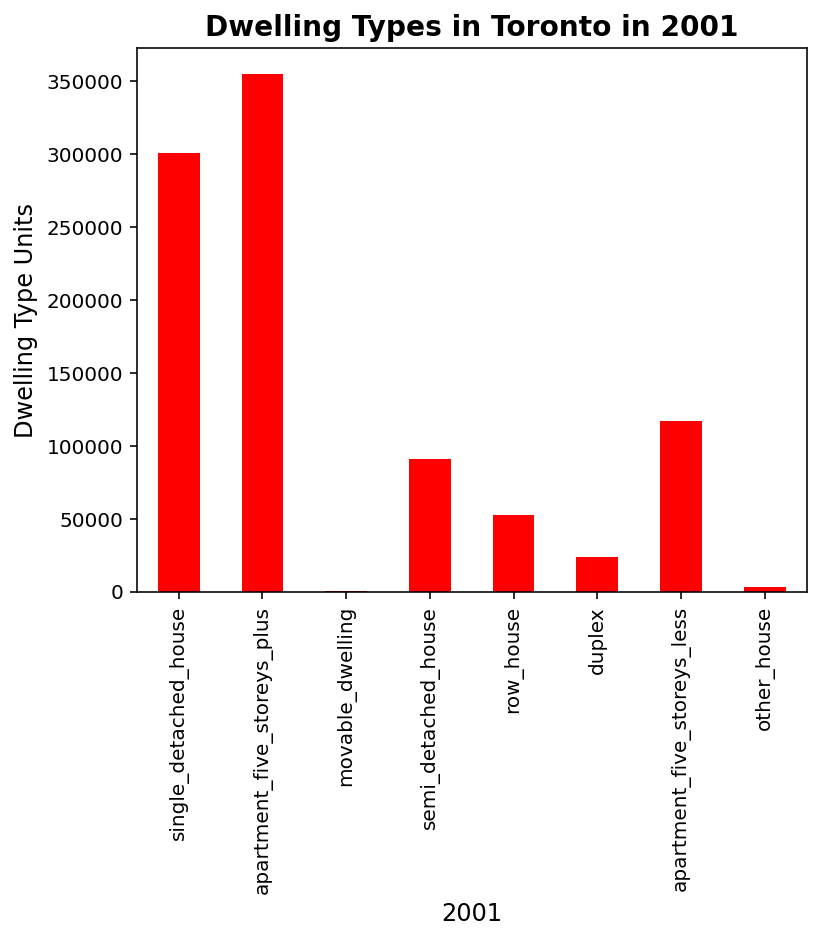
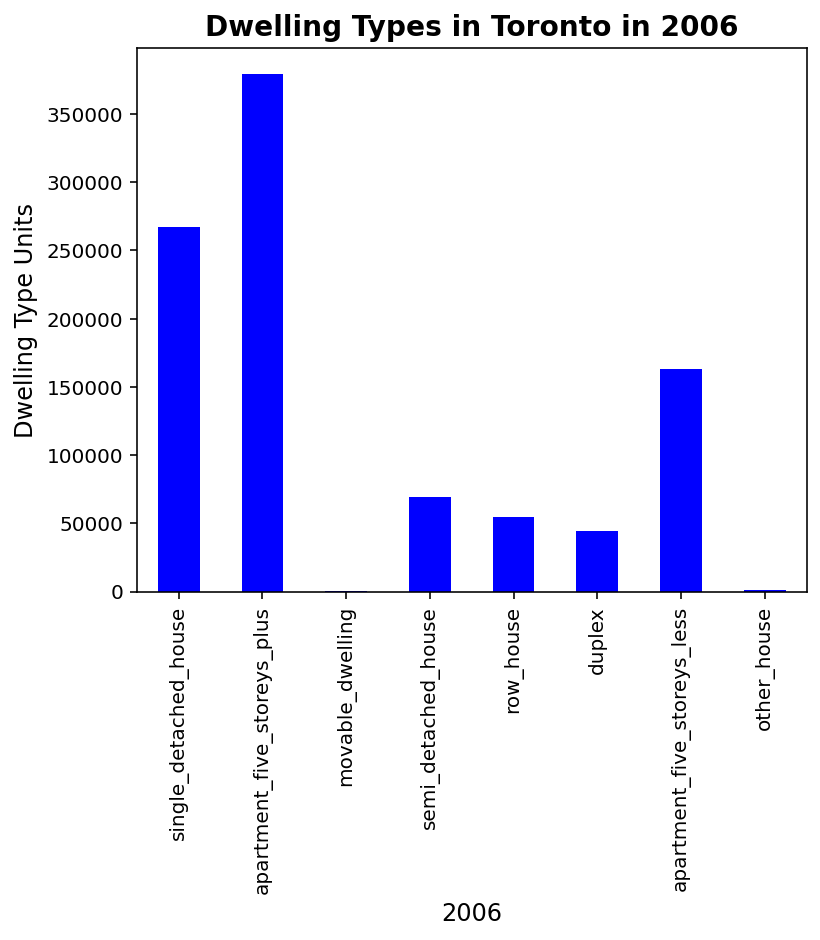
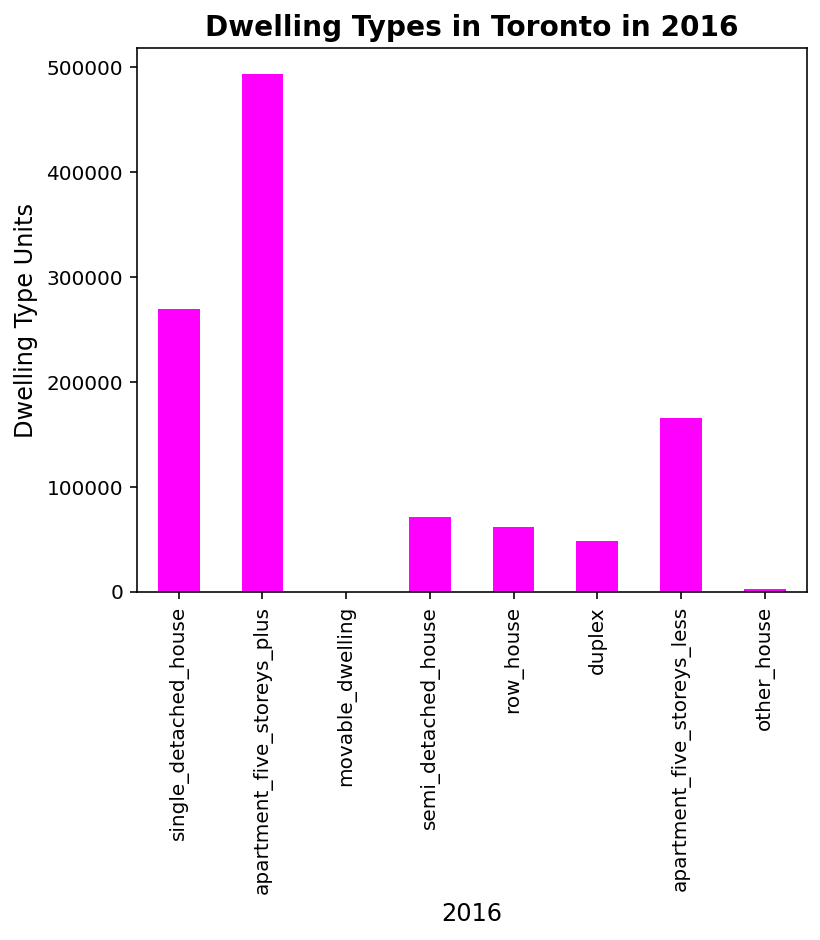
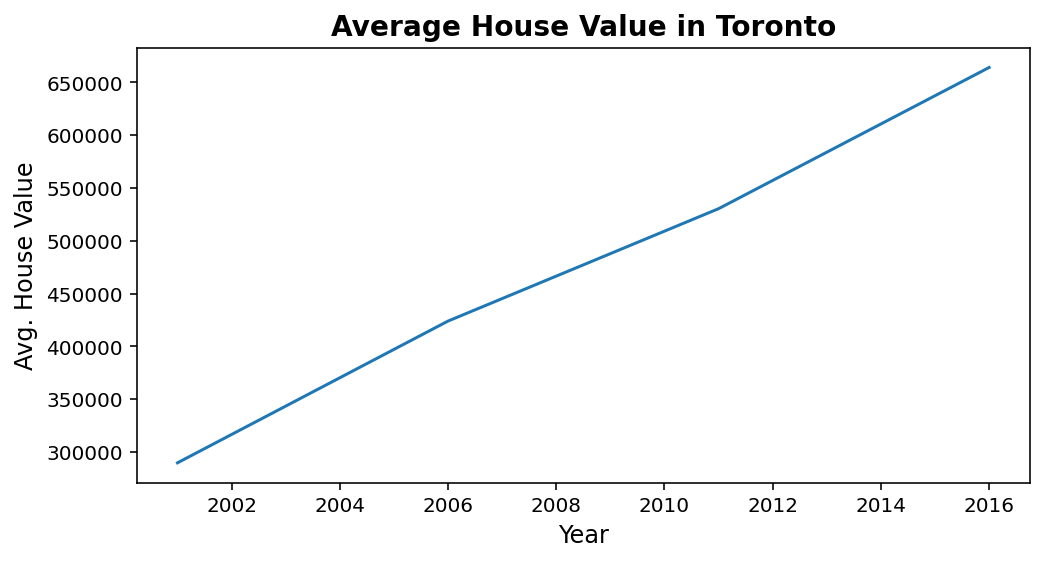
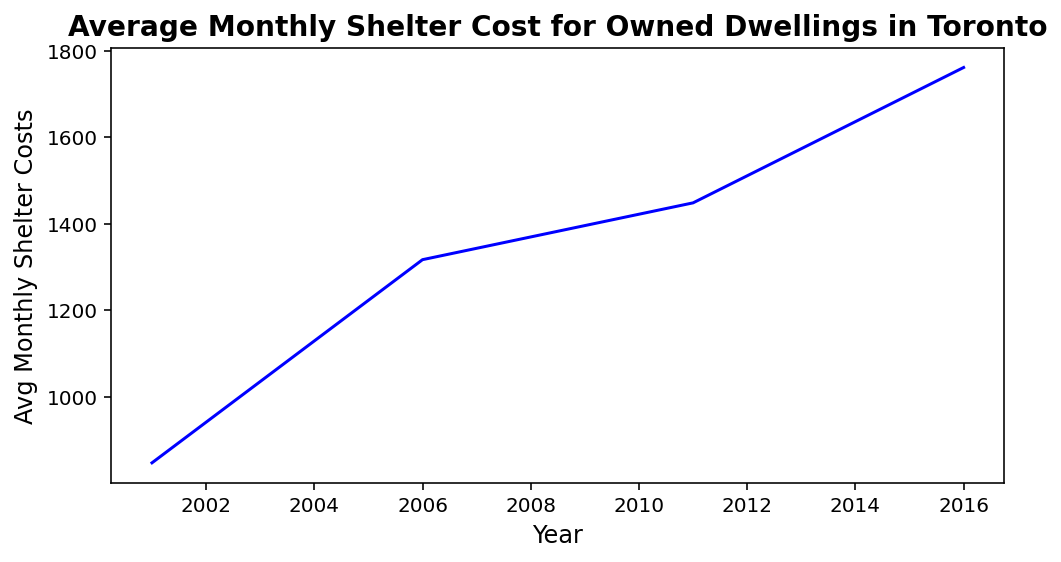

In [20]:
dashboard.servable()

# Debugging

Note: Some of the Plotly express plots may not render in the notebook through the panel functions.

However, you can test each plot by uncommenting the following code

In [ ]:
# neighbourhood_map().show()

In [ ]:
# create_bar_chart(data, title, xlabel, ylabel, color)

# # Bar chart for 2001
# create_bar_chart(mean_dwelling_type_per_year.loc[2001], "Dwelling Types in Toronto in 2001", "2001", "Dwelling Type Units", "red")

# # Bar chart for 2006
# create_bar_chart(df_dwelling_units.loc[2006], "Dwelling Types in Toronto in 2006", "2006", "Dwelling Type Units", "blue")

# # Bar chart for 2011
# create_bar_chart(df_dwelling_units.loc[2011], "Dwelling Types in Toronto in 2011", "2011", "Dwelling Type Units", "orange")

# # Bar chart for 2016
# create_bar_chart(df_dwelling_units.loc[2016], "Dwelling Types in Toronto in 2016", "2016", "Dwelling Type Units", "magenta")

In [ ]:
# create_line_chart(data, title, xlabel, ylabel, color)

# # Line chart for owned dwellings
# create_line_chart(average_costs_df["shelter_costs_owned"], "Average Monthly Shelter Cost for Owned Dwellings in Toronto", "Year", "Avg Monthly Shelter Costs", "blue")

# # Line chart for rented dwellings
# create_line_chart(df_avg_costs["shelter_costs_rented"], "Average Monthly Shelter Cost for Rented Dwellings in Toronto", "Year", "Avg Monthly Shelter Costs", "orange")

In [ ]:
#average_house_value()

In [ ]:
# average_value_by_neighbourhood()

In [ ]:
# number_dwelling_types()

In [ ]:
# average_house_value_snapshot()

In [ ]:
# top_most_expensive_neighbourhoods()

In [ ]:
# sunburts_cost_analysis()